In [37]:
# Librerias
import os
from bs4 import BeautifulSoup, NavigableString
from unidecode import unidecode
import datetime
import traceback
import json
import csv
import pandas as pd
import jellyfish
from collections import OrderedDict
import matplotlib
import matplotlib.pyplot as plt
import re
from threading import Thread
import queue

In [38]:
# Parámetros
sourceDataFolder = "1-input"

bumeraniterationNumber = "5"
bumeranRootPath = sourceDataFolder + r"\main\bumeran\iteration-" + bumeraniterationNumber

intermFilesFolder = "2-process"
mergedMainFolder = "3-output"
otherOutputFolder = "../2-data-preparation/1-input/main/"
logsFolder = "4-logs"

dataVisualizationTopLimit = 20

counterIn = 0
counterOut = 0

In [39]:
# Funciones utilitarias
def find_nth(haystack, needle, n):
    start = haystack.find(needle)
    while start >= 0 and n > 1:
        start = haystack.find(needle, start+len(needle))
        n -= 1
    return start

def find_nth_right(haystack, needle, n):
    start = haystack.rfind(needle)
    while start >= 0 and n > 1:
        start = haystack.rfind(needle, 0, start-len(needle))
        n -= 1
    return start

def parseLineBreaksAndAccents(text):
  return unidecode(" ".join(text.split()))

def parseNames(text):
  return text.strip().title()

def findTags(tag, color):
  #if tag.find("span", {"style": 'font-size:10.0pt;font-family:"Arial",sans-serif;mso-fareast-font-family:\n"Times New Roman";color:' + color }) is not None: 
  #  print(parseNames(parseLineBreaksAndAccents(tag.find("span", {"style": 'font-size:10.0pt;font-family:"Arial",sans-serif;mso-fareast-font-family:\n"Times New Roman";color:' + color }).text)))
  return tag.find("span", {"style": 'font-size:10.0pt;font-family:"Arial",sans-serif;mso-fareast-font-family:\n"Times New Roman";color:' + color })

def getChildIndex(mainChildTags, title, color):
  return next((index for index, tag in enumerate(mainChildTags) if ( parseNames(parseLineBreaksAndAccents(findTags(tag, color).text)) == title if findTags(tag, color) else False )), None)

def getSectionsIndexes(mainChildTags, color):
  sectionsIndexes = []
  sectionsTitle = ["Objetivo Laboral", "Experiencia Laboral", "Educacion", "Informatica", "Idiomas", "Otros Conocimientos"]
  
  for sectionTitle in sectionsTitle:
    sectionIndex = getChildIndex(mainChildTags, sectionTitle, color)
    sectionsIndexes.append(sectionIndex)
  
  sectionsIndexes.append(len(mainChildTags)-1)
  return sectionsIndexes

def getNextSectionIndexValid(sectionsIndexes, i):
  while(not sectionsIndexes[i]):
    i = i + 1

  return sectionsIndexes[i]

def getStartAndEndIndex(sectionsIndexes, i):
  return sectionsIndexes[i], getNextSectionIndexValid(sectionsIndexes, i+1)

def readJson(path, encoding='utf-8', errors=None):
  with open (path, "r", encoding=encoding, errors=errors) as f:
    data = json.loads(f.read())
  return data

def writeJson(data, pathJson, encoding='utf-8'):
  with open(pathJson, 'w', encoding=encoding) as f:
    json.dump(data, f, indent=4, ensure_ascii=False)

def writeCsv(data, pathCsv, encoding='utf-8'):
  with open(pathCsv, 'w', newline='', encoding=encoding) as f:
    if data:
      writer = csv.DictWriter(f, fieldnames=data[0].keys(), lineterminator='\n')
      writer.writeheader()
      writer.writerows(data)
    else:
      f.write("")

def writeTxt(data, pathTxt, encoding='utf-8'):
  with open(pathTxt, 'w', encoding=encoding) as f:
    f.write(data)

In [40]:
# Funciones principales
def getFiles(rootPath, source):
  # Obteniendo todas las carpetas de los perfiles
  folders = [f for f in os.listdir(rootPath) if os.path.isdir(os.path.join(rootPath, f))]

  # Definiendo la lista de archivos final
  files = []

  # Iterando sobre las carpetas
  for folder in folders:
    # Obteniendo los archivos por cada carpeta
    folderFiles = [os.path.join(rootPath, folder, f) for f in os.listdir(os.path.join(rootPath, folder)) if os.path.isfile(os.path.join(rootPath, folder, f))]

    # Agregando esos archivos a la lista de archivos final
    if folderFiles:
      files.extend(folderFiles)

  print("Archivos originales: " + str(len(files)))

  # Filtros específicos por cada origen
  if source == "bumeran":
    filesFiltered = [f for f in files if ("\Has recibido un CV para el aviso" in f)]
  else:
    filesFiltered = files

  print("Archivos filtrados solo con postulaciones: " + str(len(filesFiltered)))

  # Filtros para considerar un archivo especifico
  filterIsIn = [
    #r"1-input\main\bumeran\iteration-4\analista-calidad\Has recibido un CV para el aviso _Analista de Calidad_(76).html"
    #r"1-input\main\bumeran\iteration-4\analista-funcional\Has recibido un CV para el aviso _Analista Funcional_(110).html"
    #r"1-input\main\linkedin\iteration-2\bandeja-entrada\New application_ .NET Developer from Cesar Ospino.html"
    #r"1-input\main\bumeran\iteration-4\a-considerar\Has recibido un CV para el aviso _Practicante de Infrastructure & Cloud_(1).html"
    #r"1-input\main\bumeran\iteration-4\a-considerar\Has recibido un CV para el aviso _Practicante de Infrastructure & Cloud_.html"
    #r"1-input\main\bumeran\iteration-4\analista-calidad\Has recibido un CV para el aviso _Analista de Calidad Sr. (Test Lead)_(1).html"
    #r"1-input\main\bumeran\iteration-4\analista-calidad\Has recibido un CV para el aviso _Analista de Calidad_(1).html"
    #r"1-input\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador Senior_Full Stack_(2).html"
    #r"1-input\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador_(6).html"
    #r"1-input\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .Net Senior_(4).html"
    #r"1-input\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de Sistemas_(24).html"
    # 5 casos con estudios en blanco
    #r"1-input\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista en Analítica Jr_(50).html",
    #r"1-input\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Gestor de Servicios de TI_(132).html",
    #r"1-input\main\bumeran\iteration-4\bandeja-entrada-asistente-social\Has recibido un CV para el aviso _Asistente Social_(173).html",
    #r"1-input\main\bumeran\iteration-4\bandeja-entrada-asistente-social\Has recibido un CV para el aviso _Asistente Social_(71).html",
    #r"1-input\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial TI_(38).html"
    #r"1-input\main\bumeran\iteration-4\bandeja-entrada-asistente-social\Has recibido un CV para el aviso _Asistente Social_(196).html"
    #r"1-input\main\bumeran\iteration-5\bandeja-entrada-2019-and-before\Has recibido un CV para el aviso _Desarrollador.NET_(1).html"
    #r"1-input\main\bumeran\iteration-5\bandeja-entrada-2019-and-before\Has recibido un CV para el aviso _Desarrollador. Net_(26).html"
    #r"1-input\main\bumeran\iteration-5\analista-funcional\Has recibido un CV para el aviso _Analista Funcional_(18).html"
    #r"1-input\main\bumeran\iteration-5\analista-calidad\Has recibido un CV para el aviso _Analista de Calidad_(92).html"
    #r"1-input\main\bumeran\iteration-5\analista-calidad\Has recibido un CV para el aviso _Analista de Calidad_(108).html"
  ]
  filesFilteredIsIn = [f for f in filesFiltered if ( f in filterIsIn if filterIsIn else True )]

  # Filtros para omitir un archivo especifico
  filterIsNotIn = [
    # 3 archivos con data incompleta (se mantiene en iteracion 4 y 5)
    r"1-input\main\bumeran\iteration-5\bandeja-entrada-2022\Has recibido un CV para el aviso _Analista Programador Senior_Full Stack_(2).html",
    r"1-input\main\bumeran\iteration-5\bandeja-entrada-2022\Has recibido un CV para el aviso _Analista Programador_(6).html",
    r"1-input\main\bumeran\iteration-5\programador-net\Has recibido un CV para el aviso _Programador .Net Senior_(4).html",
  ]

  filesFilteredNotIn = [f for f in filesFilteredIsIn if ( f not in filterIsNotIn if filterIsNotIn else True )]

  print("Archivos filtrados solo con data completa: " + str(len(filesFilteredNotIn)))

  # Limites superiores e inferiores en la búsqueda de archivos
  startLimit = None
  topLimit = None
  filesFilteredLimits = filesFilteredNotIn[(startLimit-1 if startLimit else 0): (topLimit if topLimit else len(files))]

  return filesFilteredLimits

In [41]:
def getEncodingBumeran(file):
  candidateLog = ""

  encoding = "windows-1252"
  try:
    with open(file, "r", encoding="utf-16-le") as f:
      if "charset=unicode" in f.read():
        encoding = 'utf-16-le'
      else:
        raise Exception
  except Exception as e:
    try:
      with open(file, "r", encoding="windows-1252") as f:
        if "charset=windows-1252" in f.read():
          encoding = 'windows-1252'
        else:
          encoding = encoding
    except Exception as e:
      candidateLog = candidateLog + file + "\n"
      candidateLog = candidateLog + traceback.format_exc() + "\n"
      candidateLog = candidateLog + "\n"
      pass
      
  return encoding, candidateLog

In [42]:
def getCandidateBumeran(file, encoding, candidateLog):
  candidateData = {}
 
  try:
  # Abriendo el archivo
    with open(file, "r", encoding=encoding) as myFile:
      #Parseando el archivo html a soup
      soup = BeautifulSoup(myFile.read(), "lxml")

      # Obteniendo cada uno de los campos para la data

      # Fecha de postulación
      spanDates = soup.find_all("span", {"style": "color:black"})
      if len(spanDates) > 4:
        rawPostulationDate = spanDates[3].text
        postulationDate = datetime.datetime.strptime(spanDates[3].text, "%A, %B %d, %Y %I:%M %p")
      else:
        spanDates2 = soup.find_all("span", {"style": 'font-family:"Calibri",sans-serif;color:black'})
        rawPostulationDate = spanDates2[3].text
        postulationDate = datetime.datetime.strptime(spanDates2[3].text, "%A, %B %d, %Y %I:%M %p")
        
      candidateData["candidatePostulationDate"] = postulationDate.strftime("%A, %B %d, %Y %I:%M %p")

      # ID de la convocatoria
      TitleTagsText = soup.find("p", {"style": "margin-top:10.5pt;margin-right:0in;margin-bottom:10.5pt;margin-left:\n15.0pt;background:whitesmoke"}).findAll(string=True)
      cleanJobIdText = parseNames(parseLineBreaksAndAccents(TitleTagsText[3]))
      candidateData["jobId"] = cleanJobIdText[cleanJobIdText.find(":")+2:cleanJobIdText.find(")")]

      # Definiendo los colores a usar para las búsquedas según las fechas
      # En la fecha 2020-06-11 cambio el color de los titulos de cada sección
      inflexionDate = datetime.datetime(2020,6,11,12,5,0)
      colorTitle, colorSections = ("#008599", "#2192C9") if postulationDate <= inflexionDate else ("#E90066", "#0A26EE")

      # Nombre del perfil
      candidateData["jobProfileName"] = parseNames(parseLineBreaksAndAccents(soup.findAll("span", {"style": ("color:" + colorTitle) })[0].text))

      liTags = soup.find_all("ul", {"type": "disc"})[0].find_all("li")

      # Nombre del candidato
      firstLinePased = parseNames(parseLineBreaksAndAccents(liTags[0].text))
      candidateData["candidateFullName"] = firstLinePased
      
      # Pais de residencia
      expectedCivilStatusValues = ["Soltero/A", "Casado/A", "Divorciado/A", "Pareja De Hecho", "Viudo/A", "Union Libre"]
      secondLineParsed = parseNames(parseLineBreaksAndAccents(liTags[1].text))
      firstcommaIndex = secondLineParsed.find(",")
      if firstcommaIndex != -1:
        candidateData["candidateResidenceCountry"] = secondLineParsed[:firstcommaIndex]
      else:
        candidateData["candidateResidenceCountry"] = ""

      # Estado civil
      civilStatus = ""
      for value in expectedCivilStatusValues:
        if value in secondLineParsed:
          civilStatus = value
      candidateData["candidateCivilStatus"] = civilStatus

      # Numero de documento
      # Propiedad especial del rfind, el -1 coincide con el inicio del string, por lo que es lo mismo tomarlo con o sin el indice, en caso el index no sea -1
      lastSpaceIndex = secondLineParsed.rfind(" ")
      candidateData["candidateDocumentNumber"] = re.sub("[^0-9]", "", secondLineParsed[lastSpaceIndex+1:])
      
      # Fecha de nacimiento
      thirdLineParsed = parseNames(parseLineBreaksAndAccents(liTags[2].text))
      birthDate = thirdLineParsed[thirdLineParsed.find(":")+2:]
      if birthDate != "":
        candidateData["candidateBirthDate"] = datetime.datetime.strptime(thirdLineParsed[thirdLineParsed.find(":")+2:], "%d-%m-%Y").strftime("%Y-%m-%d")
      else:
        candidateData["candidateBirthDate"] = ""

      # Pais de nacimiento
      fourthLineParsed = parseNames(parseLineBreaksAndAccents(liTags[3].text))
      candidateData["candidateBirthCountry"] = fourthLineParsed[fourthLineParsed.find(":")+2:]

      # Dirección
      fifthLineParsed = parseNames(parseLineBreaksAndAccents(liTags[4].text))
      candidateData["candidateAddress"] = fifthLineParsed
    
      # Telefonos
      sixthLineParsed = parseNames(parseLineBreaksAndAccents(liTags[5].text))
      candidateData["candidateHomeNumber"] = sixthLineParsed[sixthLineParsed.find("Tel.")+5:sixthLineParsed.find("/")]
      candidateData["candidateCellphoneNumber"] = sixthLineParsed[sixthLineParsed.find("/")+2:]

      # Correo
      seventhLineParsed = parseNames(parseLineBreaksAndAccents(liTags[6].text))
      candidateData["candidateEmail"] = seventhLineParsed

      mainDivTag = soup.find_all("div", {"style": 'background-position-x:50%;background-position-y:100%'})[0]
      mainChildTags = mainDivTag.find_all(recursive=False)
      sectionsIndexes = getSectionsIndexes(mainChildTags, colorSections)

      # Objetivo laboral, salario
      startIndex, endIndex = getStartAndEndIndex(sectionsIndexes, 0)
      if startIndex and endIndex:
        if (endIndex - startIndex) == 3:
          workObjectiveTag = mainChildTags[startIndex+2]
          candidateData["workObjetive"] = ""
          candidateData["salary"] = 0
          liTags = workObjectiveTag.find_all("li")
          for liTag in liTags:
            parsedText = parseNames(parseLineBreaksAndAccents(liTag.text))
            if "Objetivo Laboral:" in parsedText:
              candidateData["workObjetive"] = parsedText[parsedText.find("Objetivo Laboral: ")+18:]
            if "Sueldo Pretendido:" in parsedText:
              candidateData["salary"] = int(parsedText[parsedText.find("$")+1:parsedText.find(".")])
        else:
          candidateData["workObjetive"] = ""
          candidateData["salary"] = 0
      else:
        candidateData["workObjetive"] = ""
        candidateData["salary"] = 0
      
      # Experiencia laboral
      startIndex, endIndex = getStartAndEndIndex(sectionsIndexes, 1)

      if startIndex and endIndex:
        workExperienceTags = mainChildTags[startIndex+2:endIndex]
        
        # Iterando sobre todos los trabajos
        daysOfExperience = 0
        for index, firstRowIndex in enumerate(range(0, len(workExperienceTags), 2)):
          firstRowTagsValues = [parseNames(parseLineBreaksAndAccents(tagValue)) for tagValue in workExperienceTags[firstRowIndex].find("span").findAll(string=True)]
          secondRowTagsValues = [parseNames(parseLineBreaksAndAccents(tagValue)) for tagValue in workExperienceTags[firstRowIndex+1].find("p").findAll(string=True)]
          workStartDateText = firstRowTagsValues[0][:firstRowTagsValues[0].find(" - ")]
          workStartDate = datetime.datetime.strptime(workStartDateText, "%d-%m-%Y")
          workEndDateText = firstRowTagsValues[0][firstRowTagsValues[0].find(" - ")+3:firstRowTagsValues[0].find(" |")]
          workEndDate = datetime.datetime.strptime(workEndDateText, "%d-%m-%Y") if workEndDateText != "Presente" else postulationDate
          daysOfWork = abs((workEndDate - workStartDate).days)
          daysOfExperience = daysOfExperience + daysOfWork
          # Obteniendo datos del último trabajo
          if index == 0:
            candidateData["lastWorkDays"] = daysOfWork
            candidateData["lastWorkCompany"] = firstRowTagsValues[1]
            candidateData["lastWorkCountry"] = firstRowTagsValues[2][:firstRowTagsValues[2].find(".")]
            candidateData["lastWorkArea"] = firstRowTagsValues[2][firstRowTagsValues[2].find(".")+2:firstRowTagsValues[2].rfind(".")]
            candidateData["lastWorkName"] = secondRowTagsValues[0]
            candidateData["lastWorkDescription"] = secondRowTagsValues[1] if len (secondRowTagsValues) > 1 else ""
        candidateData["yearsOfExperience"] = int(daysOfExperience/365)
        candidateData["worksNumber"] = int(len(workExperienceTags)/2)
      else:
        candidateData["lastWorkDays"] = 0
        candidateData["lastWorkCompany"] = ""
        candidateData["lastWorkCountry"] = ""
        candidateData["lastWorkArea"] = ""
        candidateData["lastWorkName"] = ""
        candidateData["lastWorkDescription"] = ""
        candidateData["yearsOfExperience"] = 0
        candidateData["worksNumber"] = 0
            
      # Carrera profesional (última alcanzada)
      startIndex, endIndex = getStartAndEndIndex(sectionsIndexes, 2)
      if startIndex and endIndex:
        educationTags = mainChildTags[startIndex+2:endIndex]

        #['01-05-2016 - 01-07-2016 |', 'Galaxy Training', ', Peru.', 'Programacion', '.']
        #['Arquitectura De Aplicaciones Java Ee', ', Graduado, Otro.']

        #['01-01-2013 - Presente | , Peru. .']
        #['Java Web Developer', ', Graduado, Terciario/Tecnico.']

        #['01-03-2012 - Presente |', 'Instituto De Formacion Bancaria Ifb', ', Peru. .']
        #['Adminisracion Bancaria', ', Abandonado, Terciario/Tecnico.']

        # Iterando sobre todos las educaciones
        daysOfStudy = 0
        for index, firstRowIndex in enumerate(range(0, len(educationTags), 2)):
          firstRowTagsValues = [parseNames(parseLineBreaksAndAccents(tagValue)) for tagValue in educationTags[firstRowIndex].find("span").findAll(string=True)]
          secondRowTagsValues = [parseNames(parseLineBreaksAndAccents(tagValue)) for tagValue in educationTags[firstRowIndex+1].find("p").findAll(string=True)]
          educationStartDateText = firstRowTagsValues[0][:firstRowTagsValues[0].find(" - ")]
          educationStartDate = datetime.datetime.strptime(educationStartDateText, "%d-%m-%Y")
          educationEndDateText = firstRowTagsValues[0][firstRowTagsValues[0].find(" - ")+3:firstRowTagsValues[0].find(" |")]
          educationEndDate = datetime.datetime.strptime(educationEndDateText, "%d-%m-%Y") if educationEndDateText != "Presente" else postulationDate
          daysOfEducation = abs((educationEndDate - educationStartDate).days)
          daysOfStudy = daysOfStudy + daysOfEducation
          # Obteniendo datos del último trabajo
          if index == 0:
            candidateData["lastEducationDays"] = daysOfEducation
            candidateData["lastEducationCompany"] = firstRowTagsValues[1]
            candidateData["lastEducationCountry"] = firstRowTagsValues[2][firstRowTagsValues[2].find(",")+2:firstRowTagsValues[2].find(".")]
            candidateData["lastEducationArea"] = firstRowTagsValues[3]

            firstElemSecondRow = secondRowTagsValues[0] if len(secondRowTagsValues) == 2 else "".join([secondRowTagsValues[0], secondRowTagsValues[1]])
            secondElemSecondRow = secondRowTagsValues[1] if len(secondRowTagsValues) == 2 else secondRowTagsValues[2]

            #candidateData["str"] = str(secondRowTagsValues)
            #candidateData["len"] = len(secondRowTagsValues)
            candidateData["lastEducationName"] = firstElemSecondRow
            candidateData["lastEducationStatus"] = secondElemSecondRow[secondElemSecondRow.find(",")+2:secondElemSecondRow.rfind(",")]
            candidateData["lastEducationDegree"] = secondElemSecondRow[secondElemSecondRow.rfind(",")+2:secondElemSecondRow.find(".")]
        candidateData["yearsOfStudy"] = int(daysOfStudy/365)
        candidateData["studiesNumber"] = int(len(educationTags)/2)
      else:
        candidateData["lastEducationDays"] = 0
        candidateData["lastEducationCompany"] = ""
        candidateData["lastEducationCountry"] = ""
        candidateData["lastEducationArea"] = ""
        candidateData["lastEducationName"] = ""
        candidateData["lastEducationStatus"] = ""
        candidateData["lastEducationDegree"] = ""
        candidateData["yearsOfStudy"] = 0
        candidateData["studiesNumber"] = 0
      
      # Habilidades técnicas
      startIndex, endIndex = getStartAndEndIndex(sectionsIndexes, 3)
      #print(startIndex, endIndex)
      if startIndex and endIndex:
        # Falta mejorar la validación (algunos tienen solo u, solo carrera o ninguno)
        liTags = mainChildTags[startIndex+2].find_all("li")
        candidateData["technicalSkills"] = len(liTags)
      else:
        candidateData["technicalSkills"] = 0
      
      # Lenguajes
      startIndex, endIndex = getStartAndEndIndex(sectionsIndexes, 4)

      if startIndex and endIndex:
        # Falta mejorar la validación (algunos tienen solo u, solo carrera o ninguno)
        liTags = mainChildTags[startIndex+2].find_all("li")
        candidateData["languages"] = len(liTags)
      else:
        candidateData["languages"] = 0

      # Otros conocimientos (habilidades blandas)
      startIndex, endIndex = getStartAndEndIndex(sectionsIndexes, 5)

      if startIndex and endIndex:
        liTags = mainChildTags[startIndex+2].find_all("li")
        candidateData["otherSkills"] = len(liTags)
      else:
        candidateData["otherSkills"] = 0

  except Exception as e:
    candidateData = {}
    candidateLog = candidateLog + str(file) + "\n"
    candidateLog = candidateLog + traceback.format_exc() + "\n"
    candidateLog = candidateLog + "\n"
    pass

  return candidateData, candidateLog

In [43]:
class Worker(Thread):
  def __init__(self, queue, filesCount):
    Thread.__init__(self)
    self.queue = queue
    self.filesCount = filesCount
    self.candidateData = []
    self.candidateLog = []

  def run(self):
    while True:
      elem = self.queue.get()
      if not elem:
        break
      
      index, file = elem["index"], elem["file"]

      if index % 500 == 0:
        print(str(index) + "/" + str(self.filesCount) + " archivos analizados")
      
      # Obteniendo el encoding por cada archivo
      encoding, candidateLog = getEncodingBumeran(file)

      # Obteniendo los datos por cada archivo
      candidateData, candidateLog = getCandidateBumeran(file, encoding, candidateLog)
      
      if candidateData:
        self.candidateData.append(candidateData)
      if candidateLog:
        self.candidateLog.append(candidateLog)

      self.queue.task_done()

In [44]:
def iterateCandidateQueue(files, workersNumber):
  filesCount = len(files)

  q = queue.Queue()
  for index, file in enumerate(files):
    q.put({"index": index, "file": file})
  
  for _ in range(workersNumber):
    q.put({})
  
  workers = []
  for _ in range(workersNumber):
      worker = Worker(q, filesCount)
      worker.start()
      workers.append(worker)
  
  for worker in workers:
      worker.join()
  
  data = []
  log = ""
  for worker in workers:
    data.extend(worker.candidateData)
    log = log + "".join(worker.candidateLog)

  return data, log

In [45]:
def readAndWriteMain(source):
  # Definiendo la carpeta raiz de los archivos a buscar, según el origen
  rootPath = bumeranRootPath

  # Obteniendo la lista de archivos, según el origen
  files = getFiles(rootPath, source)

  # Definiendo el numero de hilos
  workersNumber = 1

  # Obteniendo los datos de candidatos y el log
  data, log = iterateCandidateQueue(files, workersNumber)

  # Realizando un ordenamiento por fecha de postulación, en orden descendente
  #data = sorted(data, key=lambda x: (x["candidatePostulationDate"]), reverse=True)

  # Escribiendo la data de los candidatos (json y csv)
  writeJson(data, os.path.join(intermFilesFolder, source + '.json'))
  writeCsv(data, os.path.join(intermFilesFolder, source + '.csv'))

  # Escribiendo el log de errores
  writeTxt(log, os.path.join(logsFolder, source, datetime.datetime.now().strftime("%Y-%m-%d %H-%M-%S") + ".txt"), 'utf-16')

  return data

In [46]:
def readAndWriteMergedMain(mainData):
  mergedMainData = []
  for elem in mainData:
    if (elem):
      mergedMainData.extend(elem)

  writeJson(mergedMainData, os.path.join(mergedMainFolder, "result.json"), 'utf-8')
  writeCsv(mergedMainData, os.path.join(mergedMainFolder, "result.csv"), 'utf-8')

  writeJson(mergedMainData, os.path.join(otherOutputFolder, "result.json"), 'utf-8')
  writeCsv(mergedMainData, os.path.join(otherOutputFolder, "result.csv"), 'utf-8')

  return mergedMainData

In [47]:
def visualizeData(mergedMainData):
  df = pd.DataFrame(mergedMainData)

  print(df.count())

  columns = [elem for elem in df.columns if elem not in ["candidatePostulationDate", "candidateFullName"]]

  for column in columns:
    topDf = df[column].value_counts()[:dataVisualizationTopLimit]
    print(topDf)
    y_axis = list(reversed(topDf.index))
    x_axis = list(reversed(topDf.values))
    plt.ylabel(column)
    plt.barh(y_axis, x_axis)
    plt.show()

Inicio: 2023-05-20 13:47:57.030420
Se inició el procesamiento
Archivos originales: 10230
Archivos filtrados solo con postulaciones: 10228
Archivos filtrados solo con data completa: 10225
0/10225 archivos analizados
500/10225 archivos analizados
1000/10225 archivos analizados
1500/10225 archivos analizados
2000/10225 archivos analizados
2500/10225 archivos analizados
3000/10225 archivos analizados
3500/10225 archivos analizados
4000/10225 archivos analizados
4500/10225 archivos analizados
5000/10225 archivos analizados
5500/10225 archivos analizados
6000/10225 archivos analizados
6500/10225 archivos analizados
7000/10225 archivos analizados
7500/10225 archivos analizados
8000/10225 archivos analizados
8500/10225 archivos analizados
9000/10225 archivos analizados
9500/10225 archivos analizados
10000/10225 archivos analizados
Se terminó de procesar Bumeran
Se terminó de unir la data principal
candidatePostulationDate     10100
jobId                        10100
jobProfileName             

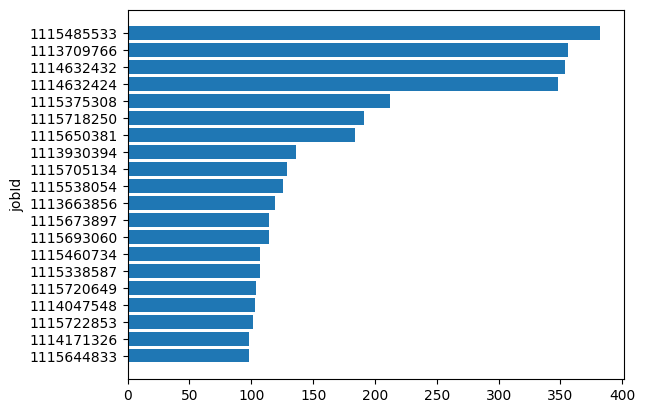

Practicante De Recursos Humanos                    942
Ejecutivo Comercial                                430
Analista Funcional                                 368
Gestor De Servicios De Ti                          356
Asistente De Recursos Humanos                      354
Jefe De Proyecto - Analytics & Ai                  293
Asistente Social                                   283
Practicante De Infrastructure & Cloud              278
Programador .Net                                   269
Analista Programador                               252
Asistente De Pmo                                   243
Community Manger                                   184
Desarrollador .Net                                 178
Analista De Calidad                                175
Ejecutivo(A) Comercial Ti                          154
Jefe De Proyectos - Analytics & Ai                 151
Lider Tecnico                                      148
Jefe De Proyecto Para El Area De Analytics & Ai    139
Cloud Spec

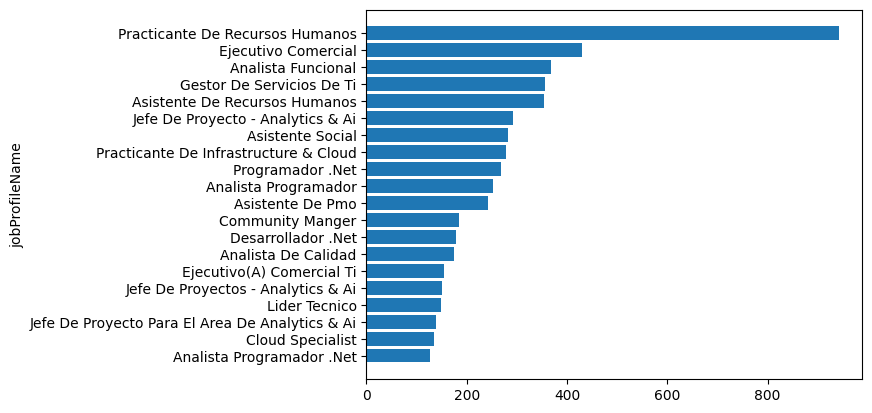

Peru                    9856
Venezuela                144
                          63
Argentina                 11
Colombia                   9
Brasil                     4
Ecuador                    3
Republica Dominicana       2
Chile                      2
Bolivia                    1
Francia                    1
Costa Rica                 1
Espana                     1
Panama                     1
El Salvador                1
Name: candidateResidenceCountry, dtype: int64


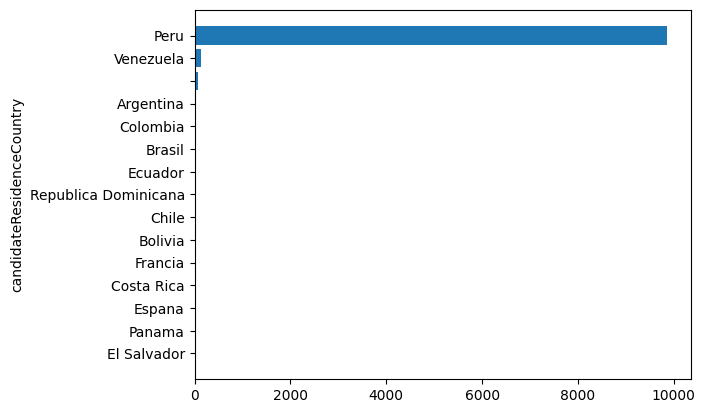

Soltero/A          7738
Casado/A           1468
                    614
Divorciado/A        124
Pareja De Hecho     108
Union Libre          45
Viudo/A               3
Name: candidateCivilStatus, dtype: int64


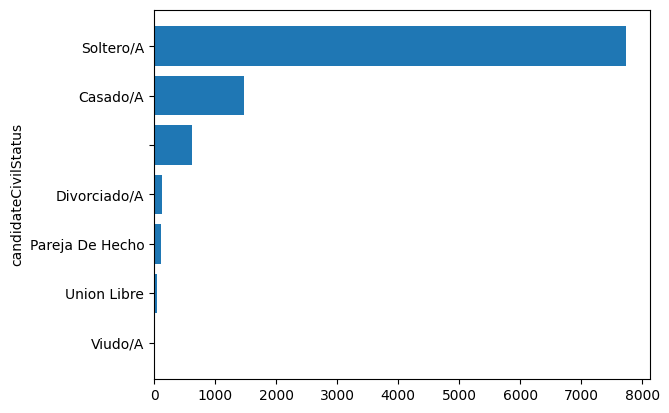

            259
43319681     78
43462768     35
41002160     27
43015660     26
18229064     23
45732690     21
10315458     18
45419217     17
42030318     15
12345678     15
40613584     14
46596341     14
44174897     14
07968889     13
44178991     13
47088768     13
70008340     13
40539275     12
46688979     12
Name: candidateDocumentNumber, dtype: int64


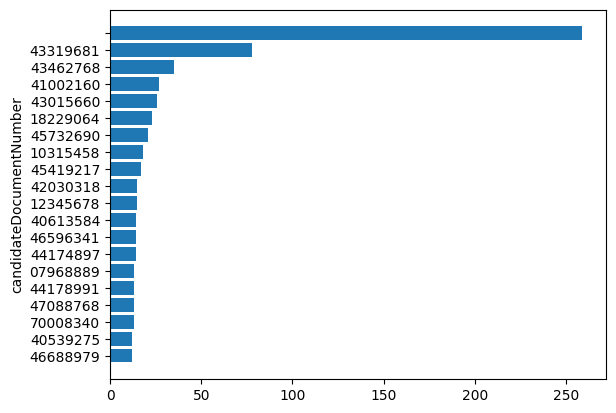

              231
1985-07-13     84
1979-09-30     42
1985-04-08     26
1986-01-18     25
1978-01-21     23
1989-02-25     22
1975-05-15     18
1988-11-18     17
1990-09-11     17
1990-12-15     17
1987-04-13     16
1980-07-24     15
1982-10-16     15
1990-02-24     14
1988-08-17     13
1968-10-29     13
1987-01-01     13
1980-11-05     12
1980-05-03     12
Name: candidateBirthDate, dtype: int64


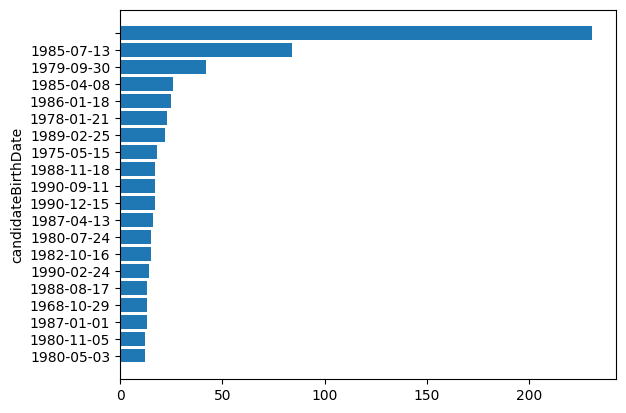

Peru                    9856
Venezuela                144
                          63
Argentina                 11
Colombia                   9
Brasil                     4
Ecuador                    3
Republica Dominicana       2
Chile                      2
Bolivia                    1
Francia                    1
Costa Rica                 1
Espana                     1
Panama                     1
El Salvador                1
Name: candidateBirthCountry, dtype: int64


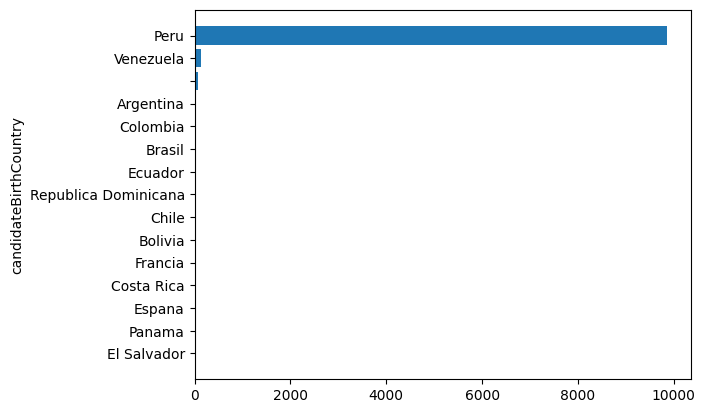

                                                                                        657
Lima, Lima, Lima, Peru                                                                   76
Neruda, Lima, Lima, Peru                                                                 46
., Lima, Lima, Peru                                                                      32
Jr Ica 950, Lima, Lima, Peru                                                             26
Calle Valladolid # 128 Urbanizacion Mayorazgo - Ate, Ate, Lima, Peru                     25
Santa Anita , Lima, Lima, Peru                                                           24
Calle 13 De Abril 910, Arequipa, Arequipa, Peru                                          21
Calera De La Merced 248, Surquillo, Lima, Peru                                           20
Begonias, Carabayllo, Lima, Peru                                                         17
-, Lima, Lima, Peru                                                             

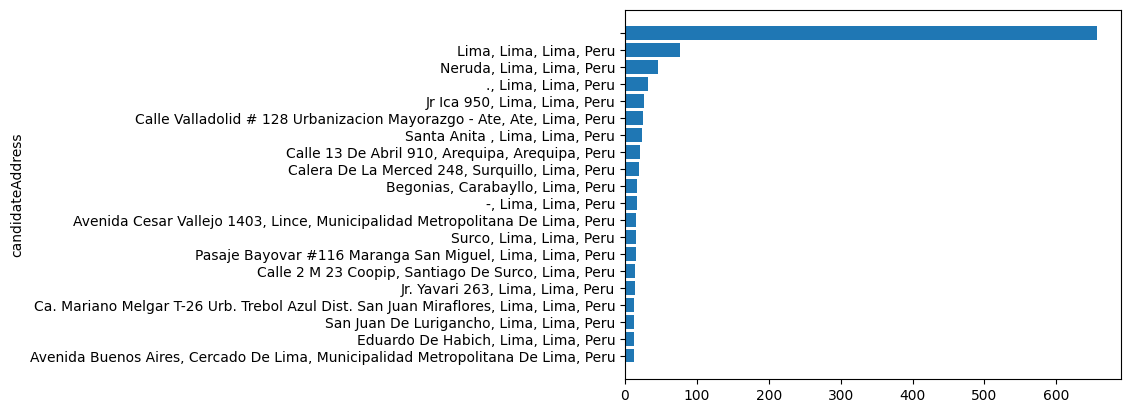

                 4878
51                682
+                 127
01                 78
511                63
51 910984054       45
51 931810142       24
+51                17
511 5748571        14
51 995384149       13
01 2580077         12
5775611 01         11
01 0               11
511 4342693        11
51 993596249        9
01 3997952          9
051 7473619         9
01 4643843          9
51 5611445          9
5221855 511         8
Name: candidateHomeNumber, dtype: int64


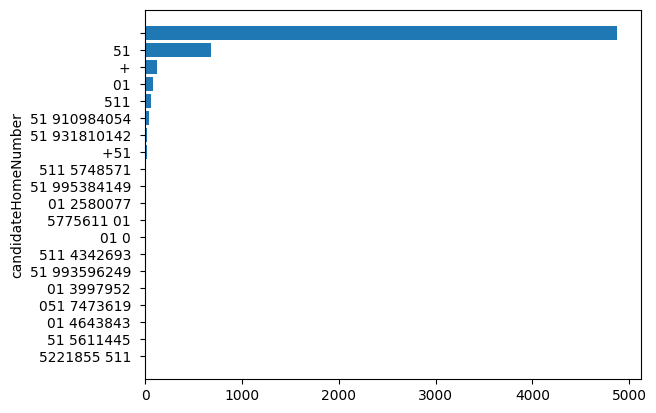

                  78
51 910984054      45
511 949346218     27
51 931810142      24
054 973583947     21
+51 950001939     20
51 994637675      18
51 949346218      15
51 997671135      15
0511 933480280    14
511 992028085     14
51 940442936      14
01 959053787      13
51 995384149      13
511 946059246     13
51 991064075      12
511 958960663     11
951901566         11
51-1 997671135    10
51 954775066      10
Name: candidateCellphoneNumber, dtype: int64


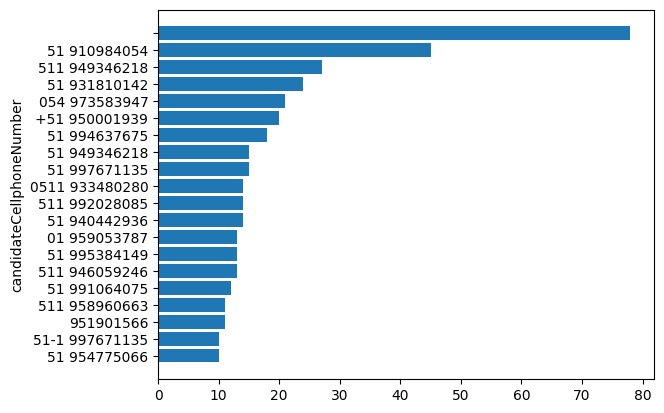

Jurqui29@Outlook.Com            78
Hcortez2011@Gmail.Com           42
Amirandac36@Gmail.Com           35
Villamoralesjulia@Gmail.Com     26
Gastoni21@Hotmail.Com           23
Alevca@Hotmail.Com              21
Paco150575@Hotmail.Com          18
Ricardo_I14@Hotmail.Com         17
Asistemas200920341@Gmail.Com    17
Eduardopassano82@Hotmail.Com    15
John.Panana@Gmail.Com           14
Leono13@Live.Com                14
Renato.Mzc1990@Gmail.Com        14
Willy.Olortegui@Gmail.Com       13
Rosa.Huirset@Gmail.Com          13
Guillermoherenciav@Gmail.Com    13
Nirvana_566@Hotmail.Com         12
Pjrcb@Yahoo.Es                  12
Alez1512@Hotmail.Com            12
Randy.Silva@Gmail.Com           11
Name: candidateEmail, dtype: int64


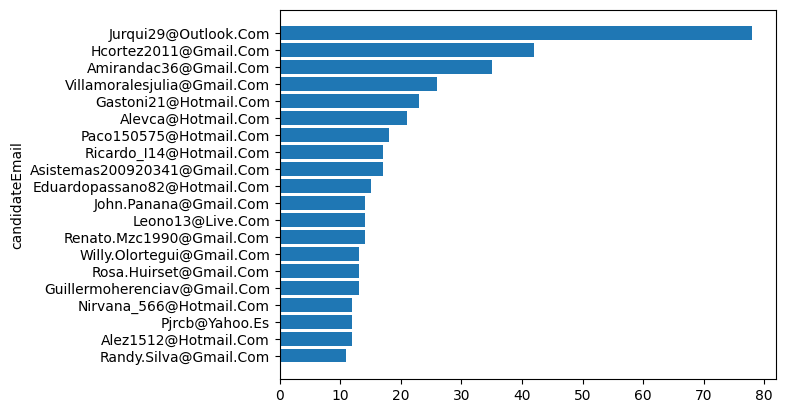

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          1262
Me Desempeno En El Area D

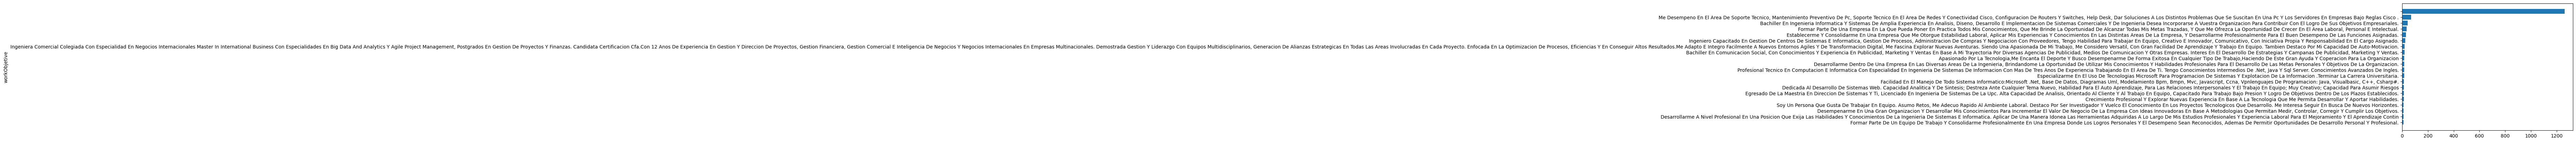

5000    610
2500    604
2000    581
3500    555
3000    543
4000    520
1500    466
6000    436
0       421
4500    400
1200    357
1800    354
1025    296
5500    296
1000    279
7000    278
6500    277
930     220
8000    201
1       199
Name: salary, dtype: int64


C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_24756\3874036009.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  topDf = df[column].value_counts()[:dataVisualizationTopLimit]


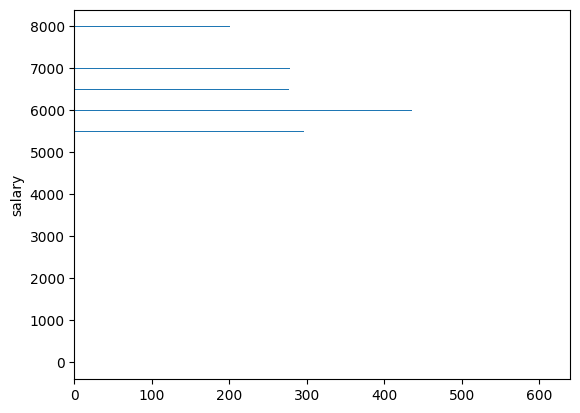

C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_24756\3874036009.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  topDf = df[column].value_counts()[:dataVisualizationTopLimit]


0      589
61     158
153    152
92     150
122    146
365    133
184    101
31      88
212     87
214     82
91      81
181     80
334     79
151     79
273     74
183     69
59      64
275     64
366     63
243     58
Name: lastWorkDays, dtype: int64


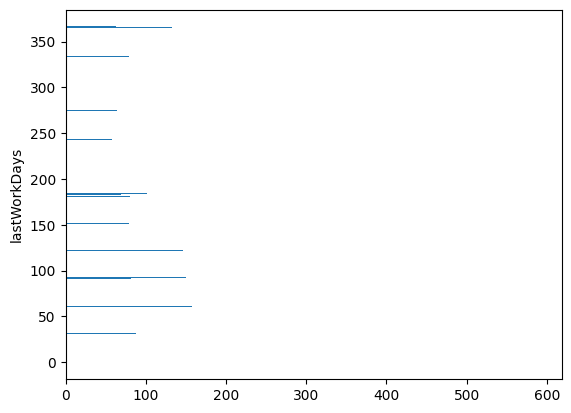

                                            558
Canvia                                      132
Freelance (Clientes)                         78
Global Hitss                                 69
Everis                                       56
Independiente                                55
Mdp Consulting                               52
Indra                                        48
Tata Consultancy Services                    38
Banco De Credito Del Peru                    38
Everis Peru Sac                              33
Pontificia Universidad Catolica Del Peru     26
Panacea Consultores S.A.                     26
Experis                                      25
Everis Peru                                  24
Tgestiona                                    24
Onpe                                         23
Mdp                                          22
Telefonica Del Peru                          22
Freelance                                    22
Name: lastWorkCompany, dtype: int64


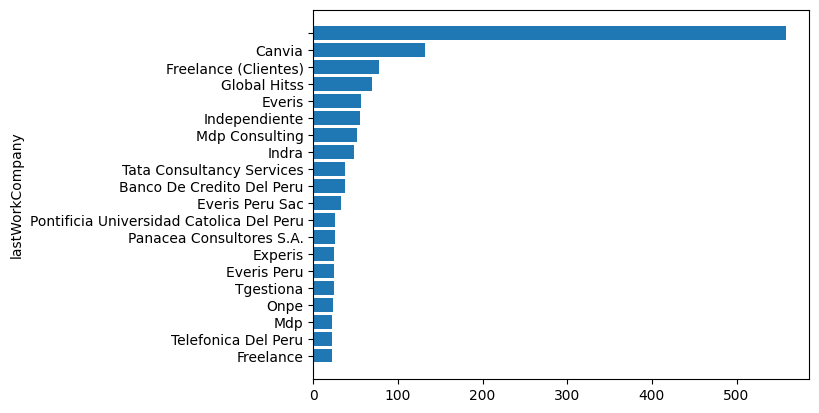

Peru              9367
                   558
Estados Unidos      31
Venezuela           25
Espana              23
Colombia            17
Brasil              16
Chile               12
Argentina            7
Ecuador              7
Mexico               4
Albania              3
Reino Unido          3
Costa Rica           3
Finlandia            2
Australia            2
Francia              2
Italia               2
Paises Bajos         2
Panama               2
Name: lastWorkCountry, dtype: int64


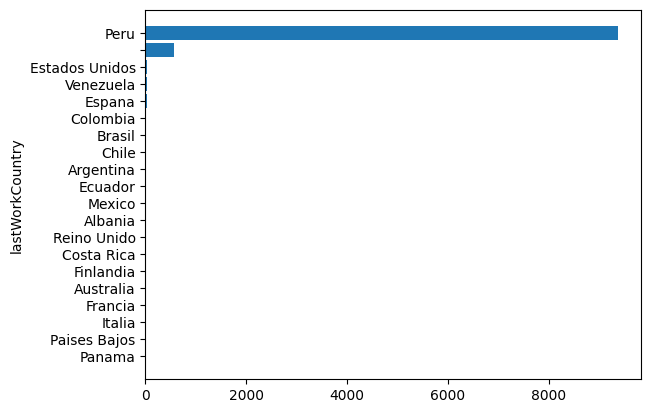

Tecnologia / Sistemas            1038
Tecnologias De La Informacion    1020
Liderazgo De Proyecto             585
Programacion                      577
                                  558
Comercial                         538
Sistemas                          487
Recursos Humanos                  430
Ventas                            261
Administracion                    256
Analisis De Datos                 235
Analisis Funcional                221
Infraestructura                   214
Soporte Tecnico                   192
Atencion Al Cliente               162
Seguridad Informatica             156
Otras Ingenierias                 151
Desarrollo De Negocios            131
Testing / Qa / Qc                 128
Administracion De Personal        115
Name: lastWorkArea, dtype: int64


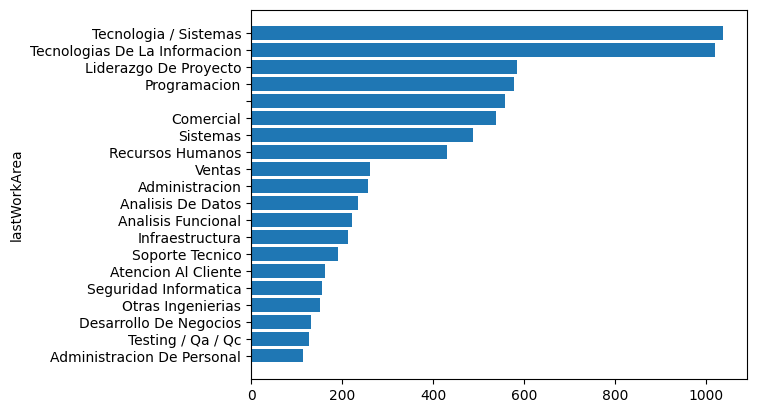

                                                558
Analista Programador                            393
Analista De Sistemas                            190
Analista Funcional                              119
Jefe De Proyectos                                83
Trabajadora Social                               80
Supervisor De Infraestructura De Redes Cisco     78
Asistente Administrativo                         69
Project Manager                                  54
Asesor Comercial                                 54
Practicante                                      51
Ejecutivo Comercial                              49
Asistente De Recursos Humanos                    49
Analista                                         49
Analista De Sistemas Senior                      47
Programador                                      38
Key Account Manager                              38
Jefe De Sistemas                                 37
Lider Tecnico                                    36
Soporte Tecn

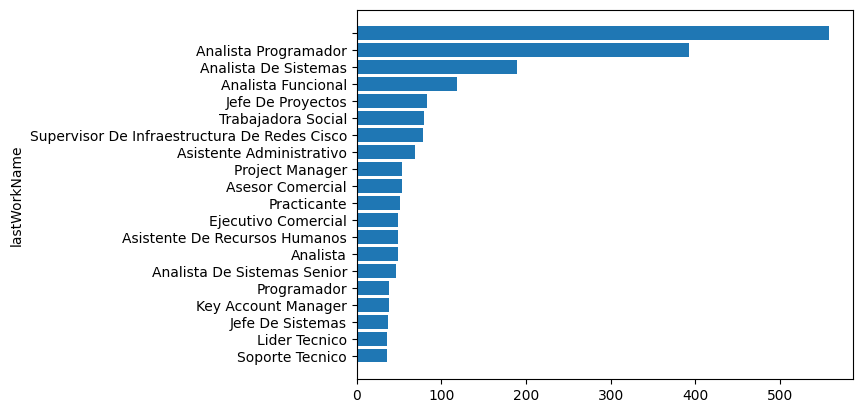

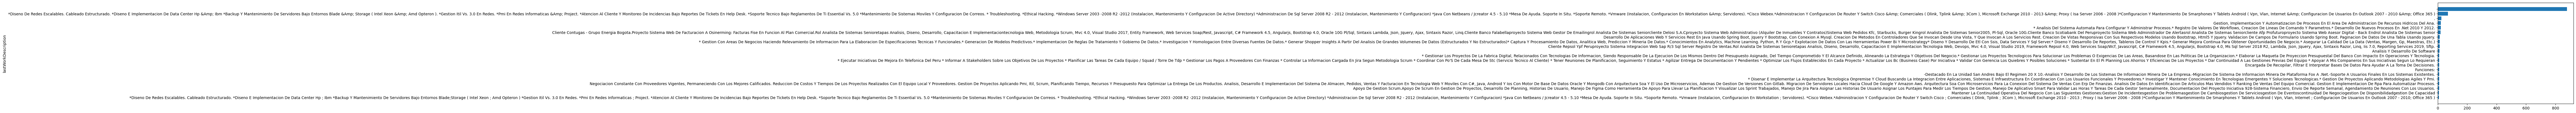

0     1149
4      731
5      690
8      673
7      661
6      648
2      642
1      635
3      619
9      529
10     495
11     422
12     305
13     303
15     255
14     246
16     174
17     127
19     110
18     104
Name: yearsOfExperience, dtype: int64


C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_24756\3874036009.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  topDf = df[column].value_counts()[:dataVisualizationTopLimit]


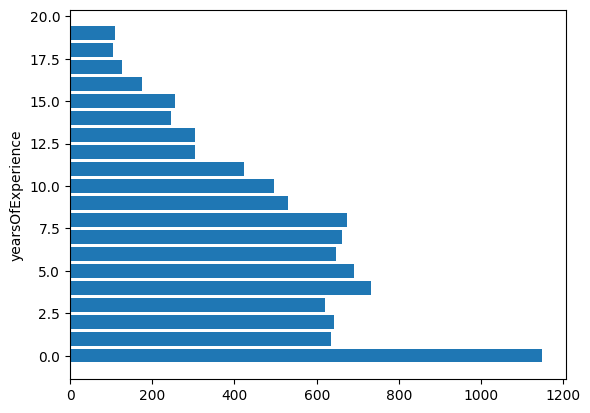

C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_24756\3874036009.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  topDf = df[column].value_counts()[:dataVisualizationTopLimit]


5     1284
4     1176
6     1039
3     1008
7      926
8      729
2      728
1      650
0      558
9      523
10     405
11     271
12     238
13     148
14     118
15      90
17      59
16      45
19      35
18      29
Name: worksNumber, dtype: int64


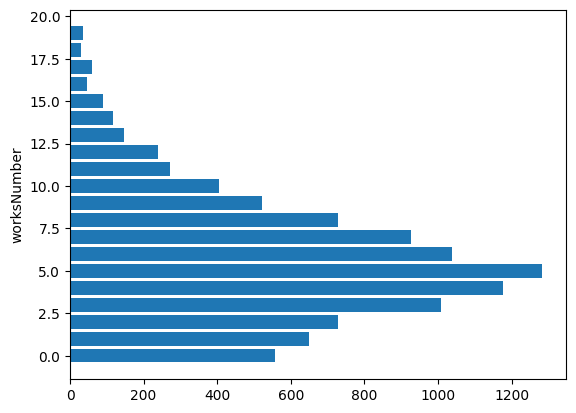

0       689
31      307
61      229
30      204
1736    196
92      153
1705    137
122     135
1948    126
153     120
2101    102
1795     99
91       87
1826     80
183      65
1157     63
1218     61
1675     60
123      59
1096     59
Name: lastEducationDays, dtype: int64


C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_24756\3874036009.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  topDf = df[column].value_counts()[:dataVisualizationTopLimit]


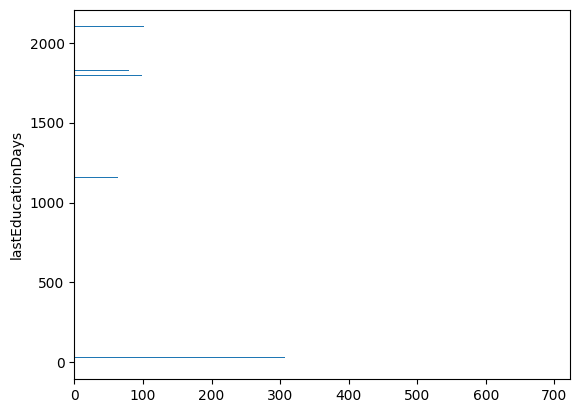

Universidad Peruana De Ciencias Aplicadas    564
Universidad Tecnologica Del Peru             346
Pontificia Universidad Catolica Del Peru     327
Universidad Nacional Mayor De San Marcos     300
Upc                                          294
Universidad Privada Del Norte                293
Universidad Esan                             236
Universidad De Lima                          219
Universidad Cesar Vallejo                    219
Cibertec                                     212
Instituto Cibertec                           200
Universidad Nacional De Ingenieria           197
Universidad De San Martin De Porres          187
Universidad Ricardo Palma                    179
Universidad Nacional Federico Villarreal     177
Universidad Inca Garcilaso De La Vega        168
Isil                                         168
Utp                                          159
Universidad San Ignacio De Loyola            137
                                             123
Name: lastEducationC

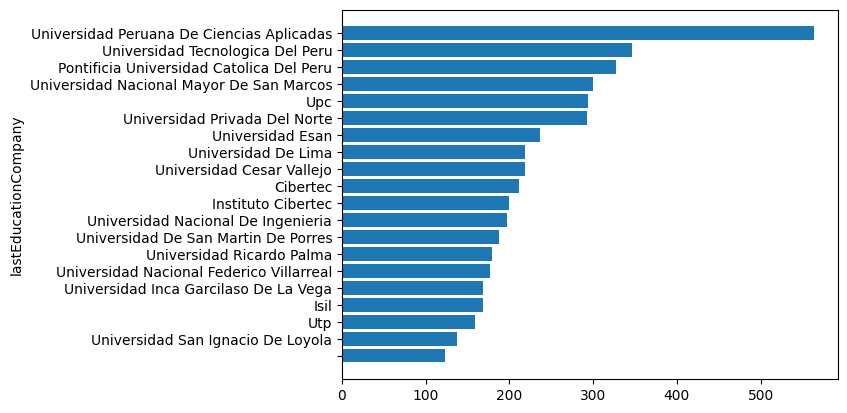

Peru              9369
Espana             196
Venezuela          162
                   123
Estados Unidos      77
Mexico              34
Argentina           20
Colombia            19
Brasil              18
Chile               18
Costa Rica          14
Canada               8
Bolivia              6
Ecuador              6
Australia            5
Francia              5
India                3
Alemania             3
Cuba                 2
Internacional        2
Name: lastEducationCountry, dtype: int64


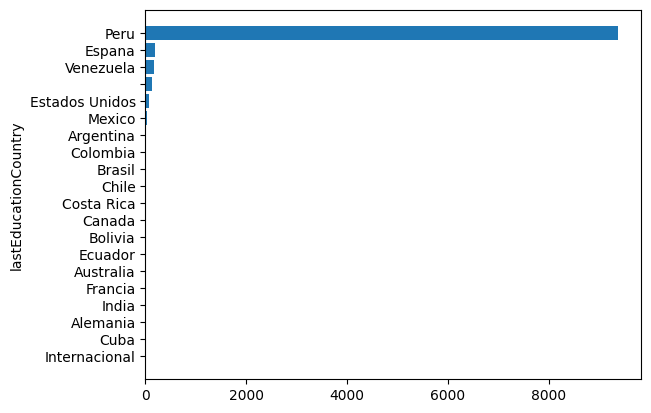

Ing. En Sistemas                  2300
Tecnologias De La Informacion     1225
Adm. De Empresas                  1132
Ing. Informatica                   612
Ing. Industrial                    489
Computacion / Informatica          475
Marketing / Comercializacion       367
Recursos Humanos / Relac. Ind.     354
Psicologia                         347
Otra                               339
Ing. - Otros                       191
Trabajo Social                     142
Analisis De Sistemas               138
Ing. Telecomunicaciones            130
                                   123
Programacion                       122
Telecomunicaciones                 118
Procesos / Calidad Total           104
Finanzas                            95
Bachiller                           91
Name: lastEducationArea, dtype: int64


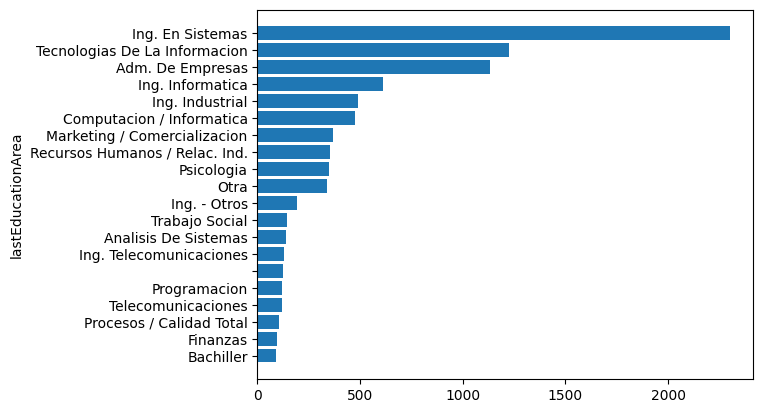

Ingenieria De Sistemas                       776
Ingenieria Industrial                        268
Psicologia                                   244
Administracion De Empresas                   193
Ingeniero De Sistemas                        181
Computacion E Informatica                    165
Ingenieria De Sistemas E Informatica         150
Administracion                               124
                                             123
Bachiller En Ingenieria De Sistemas           90
Trabajo Social                                67
Mba                                           62
Ingenieria De Redes Y Comunicaciones          61
Ingenieria Informatica                        60
Administracion Y Negocios Internacionales     54
Ingles                                        54
Ingenieria De Software                        54
Marketing                                     51
Ingenieria De Computacion Y Sistemas          49
Ingenieria De Sistemas De Informacion         49
Name: lastEducationN

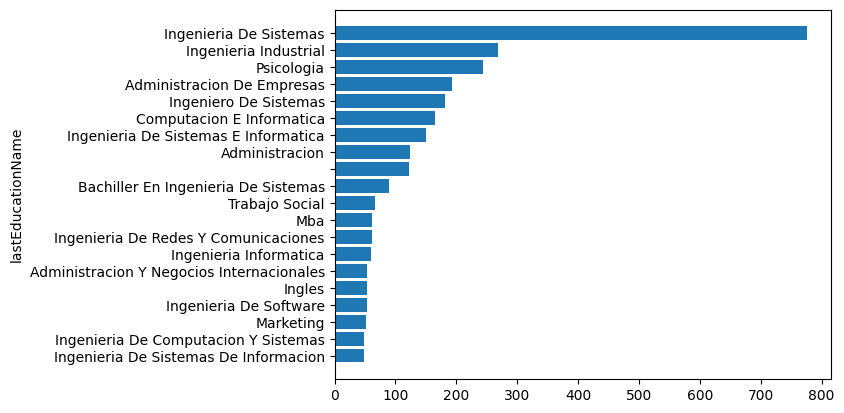

Graduado      6527
En Curso      3292
Abandonado     157
               124
Name: lastEducationStatus, dtype: int64


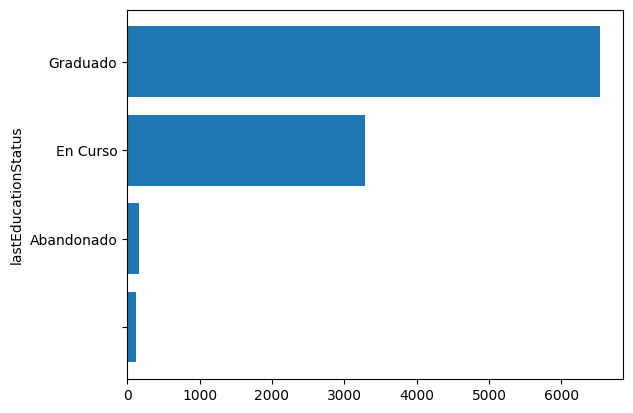

Universitario        4965
Otro                 2237
Posgrado             1171
Terciario/Tecnico     978
Master                602
                      123
Doctorado              13
Secundario             11
Name: lastEducationDegree, dtype: int64


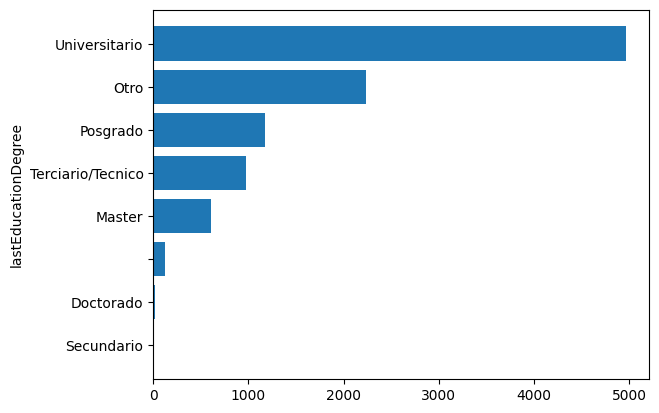

5     1653
6     1345
4     1312
7     1157
8      876
3      668
9      589
10     469
11     336
2      290
12     251
0      200
13     186
14     127
15     107
1       92
16      83
18      58
19      51
20      49
Name: yearsOfStudy, dtype: int64


C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_24756\3874036009.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  topDf = df[column].value_counts()[:dataVisualizationTopLimit]


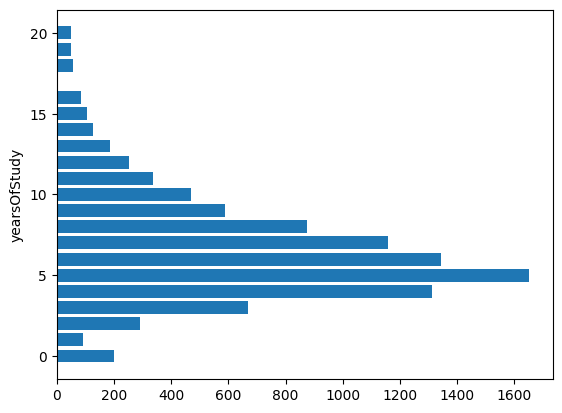

1     3753
2     2327
3     1156
4      704
5      464
6      421
7      282
8      190
9      142
0      123
11     117
10      89
12      69
14      53
13      43
16      25
15      22
20      19
17      17
18      17
Name: studiesNumber, dtype: int64


C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_24756\3874036009.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  topDf = df[column].value_counts()[:dataVisualizationTopLimit]


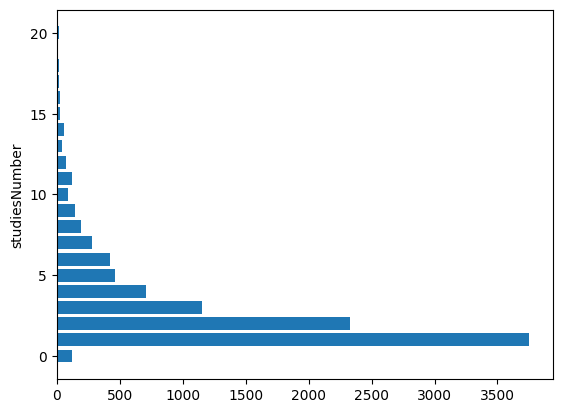

C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_24756\3874036009.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  topDf = df[column].value_counts()[:dataVisualizationTopLimit]


0     1195
1     1105
3      847
2      798
4      668
5      573
6      517
7      484
9      445
8      419
11     339
10     335
12     257
13     240
16     231
14     184
15     159
17     126
18     118
21      92
Name: technicalSkills, dtype: int64


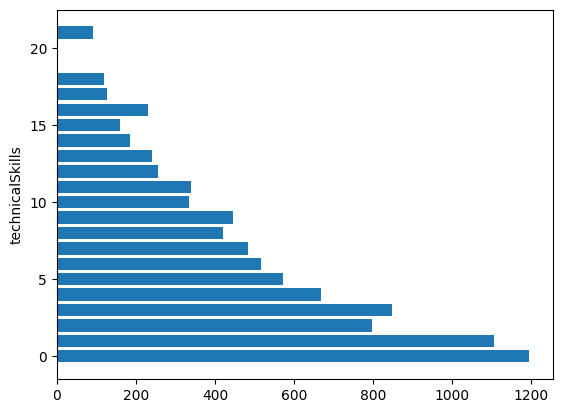

1    7046
2    1953
0     746
3     299
4      55
5       1
Name: languages, dtype: int64


C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_24756\3874036009.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  topDf = df[column].value_counts()[:dataVisualizationTopLimit]


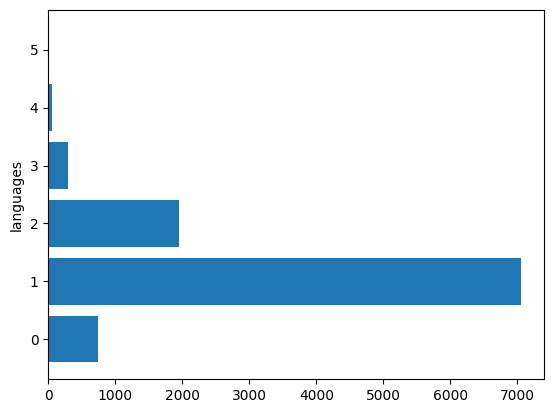

0     2331
1     1726
2     1157
3      827
4      736
5      632
6      489
7      430
8      333
9      274
10     211
11     173
12     138
13     113
14      89
15      69
17      50
16      49
20      35
19      32
Name: otherSkills, dtype: int64


C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_24756\3874036009.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  topDf = df[column].value_counts()[:dataVisualizationTopLimit]


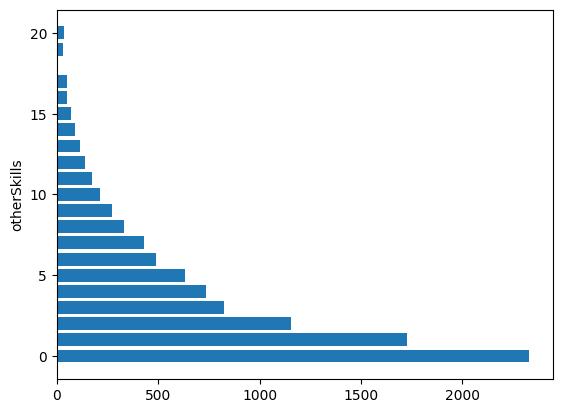

Fin: 2023-05-20 13:50:06.339881
Tiempo: 0:02:09.309461


In [48]:
def main():
  # Definiendo el inicio del proceso
  startTime = datetime.datetime.now()
  print("Inicio: " + str(startTime))
  print("Se inició el procesamiento")

  # El dataset principal que sea el de bumeran
  # Los otros archivos que solo se usen para actualizar la variable objetivo
  # Esto porque los otros orígenes están incompletos y costaría llenar los campos (incluso el excel que se hizo)
  isLoadedBumeran = False
  isMergedMain = False
  #False

  # Leyendo o calculando bumeran
  bumeranData = readJson(os.path.join(intermFilesFolder, 'bumeran.json')) if isLoadedBumeran else readAndWriteMain('bumeran')
  print("Se terminó de procesar Bumeran")

  # Uniendo la data principal (bumeran + linkedin (ya no))
  mergedMainData = readJson(os.path.join(mergedMainFolder, 'result.json')) if isMergedMain else readAndWriteMergedMain([bumeranData])
  print("Se terminó de unir la data principal")

  visualizeData(mergedMainData)
  
  # Definiendo el fin del proceso
  endTime = datetime.datetime.now()
  print("Fin: " + str(endTime))
  print("Tiempo: " + str(endTime-startTime))

  #print(counterIn)
  #print(counterOut)

if __name__ == "__main__":
  main()